Student Names and IDs:

Ceylan Şentürk 161805015

Kağan Çiloğlu 161805016

In [1]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [4]:
import keras

In [5]:
import os, shutil

Veri setimiz kedi ve köpek fotoğraflarından oluşuyor. Kaggle link: https://www.kaggle.com/c/dogs-vs-cats/data İstendiği üzere, öncelikle feature extraction yapmadan, yalnızca dense layer'lardan oluşan modeller eğitip sonuçları değerlendirdik. Daha sonra feature extraction da kullanarak bir model eğitip önceki sonuçlarla karşılaştırdık.

--------------------

Our dataset consists of cat and dog photos. As requested, we first trained a model with only dense layers (without feature extraction) and evaluated the results. Then we trained a model using feature extraction and compared it with previous results.

train_dir = 'C:/Users/asus/Desktop/dogs-vs-cats-kaggle/train'
train_cats_dir = 'C:/Users/asus/Desktop/dogs-vs-cats-kaggle/train/cats'
train_dogs_dir = 'C:/Users/asus/Desktop/dogs-vs-cats-kaggle/train/dogs'
validation_dir = 'C:/Users/asus/Desktop/dogs-vs-cats-kaggle/validation'
validation_cats_dir = 'C:/Users/asus/Desktop/dogs-vs-cats-kaggle/validation/cats'
validation_dogs_dir = 'C:/Users/asus/Desktop/dogs-vs-cats-kaggle/validation/dogs'
test_dir = 'C:/Users/asus/Desktop/dogs-vs-cats-kaggle/test'
test_cats_dir = 'C:/Users/asus/Desktop/dogs-vs-cats-kaggle/test/cats'
test_dogs_dir = 'C:/Users/asus/Desktop/dogs-vs-cats-kaggle/test/dogs'

Veri seti toplam 37500 fotoğraftan oluşuyor. Biz 25000 fotoğraf kullandık. %60 train, %20 validation, %20 test set olacak şekilde ayırdık.

--------------------

The dataset consists of a total of 37500 photos. We used 25000 photos. We divided it into 60% train, 20% validation, 20% test set.

In [9]:
print('total training images:', len(os.listdir(train_cats_dir) + os.listdir(train_dogs_dir)))

total training images: 15000


In [10]:
print('total validation images:', len(os.listdir(validation_cats_dir) + os.listdir(validation_dogs_dir)))

total validation images: 5000


In [11]:
print('total test images:', len(os.listdir(test_cats_dir) + os.listdir(test_dogs_dir)))

total test images: 5000


In [26]:
from keras import layers
from keras import models
from keras.layers import Dropout
from keras import regularizers

model = models.Sequential()
model.add(layers.Flatten(input_shape=(150, 150, 3)))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Elimizde RGB formatında fotoğraflar var, ancak dense layer'lara enjekte edebilmek için flatten layer kullanarak one dimensional array'e çeviriyoruz.

Bir çok farklı model oluşturduk; farklı sayılarda dense layer'lar, farklı oranlarda drop-out'lar ile denemeler yaptık. Weight regularization için l2 regularization kullandık. Fakat overfitting ile verimli şekilde mücadele etmeye yetmedi. Bazı durumlarda l2 ve drop-out'lar modele eklendikten sonra eğitimden hiç verim alamadık. Sonuç olarak modeli basitleştirerek epoch sayısını azaltma yoluna başvurduk.

Binary classification yaptığımız için son layer'da sigmoid'i tercih ettik. Son layer'daki node sayısını 2'ye çıkarıp softmax kullanmayı da düşündük, fakat metodik olarak ne kadar uygun olacağı konusunda emin olamadık.

--------------------

We have photos in RGB format, but in order to inject it to the dense layers, we convert them to one dimensional array using flatten layers.

We created many different models; We experimented with different numbers of dense layers and drop-outs at different rates. We used l2 regularization for weight regularization. But it wasn't enough to effectively combat overfitting. In some cases, we could not get any efficiency from the training after adding l2 and drop-outs to the model. As a result, we tried to simplifying the model and reduce the number of epochs. 

Since we are doing binary classification, we preferred sigmoid in the last layer. We also considered increasing the number of nodes in the last layer to 2 and using softmax, but we were not sure how convenient it would be methodically..

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 67500)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               17280256  
_________________________________________________________________
dense_15 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 33        
Total params: 17,323,521
Trainable params: 17,323,521
Non-trainable params: 0
__________________________________________

In [28]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

Binary classification için binary_crossentropy loss func öneriliyor. Bu yüzden tercih ettik.

-----------------

Binary_crossentropy loss function is recommended for binary classification. That's why we chose it.

In [29]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=15,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 15000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [30]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (15, 150, 150, 3)
labels batch shape: (15,)


Batch size'ı düşük tutmayı seçtik, aynı anda fazla sayıda fotoğrafı analiz etmenin verimi düşürmesinden endişe ettik. Her epoch'ta 1000 adım, her adımda 15 fotoğraf, toplam 15000 (train setimizin boyutu). Validation için 250 adım, her adımda 20 fotoğraf, toplam 5000 (validation setimizin boyutu)

---------------------

We chose to keep the batch size low, worried that analyzing a large number of photos at once would reduce efficiency. 1000 steps per epoch, 15 photos per step, 15000 total (the size of our train set). 250 steps for validation, 20 photos per step, 5000 total (size of our validation set)

In [31]:
history = model.fit(
      train_generator,
      steps_per_epoch=1000,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=250)

Epoch 1/10
1000/1000 [==============================] - 130s 130ms/step - loss: 0.8321 - acc: 0.5246 - val_loss: 0.7401 - val_acc: 0.5488
Epoch 2/10
1000/1000 [==============================] - 129s 129ms/step - loss: 0.6913 - acc: 0.5756 - val_loss: 0.6615 - val_acc: 0.6122
Epoch 3/10
1000/1000 [==============================] - 129s 129ms/step - loss: 0.6668 - acc: 0.6062 - val_loss: 0.6561 - val_acc: 0.6056
Epoch 4/10
1000/1000 [==============================] - 129s 129ms/step - loss: 0.6674 - acc: 0.5944 - val_loss: 0.6523 - val_acc: 0.6186
Epoch 5/10
1000/1000 [==============================] - 132s 132ms/step - loss: 0.6561 - acc: 0.6178 - val_loss: 0.6655 - val_acc: 0.6164
Epoch 6/10
1000/1000 [==============================] - 141s 141ms/step - loss: 0.6424 - acc: 0.6266 - val_loss: 0.6945 - val_acc: 0.5796
Epoch 7/10
1000/1000 [==============================] - 141s 141ms/step - loss: 0.6371 - acc: 0.6307 - val_loss: 0.6368 - val_acc: 0.6400
Epoch 8/10
1000/1000 [============

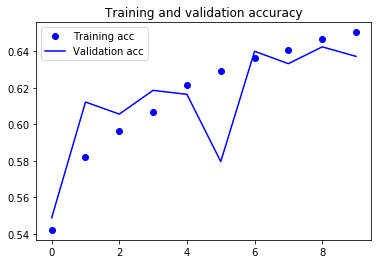

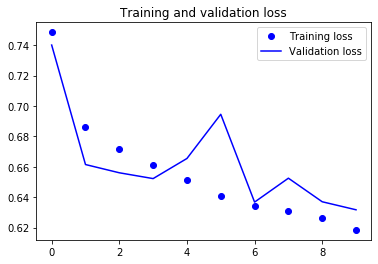

In [32]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Görüldüğü üzere, yalnızca dense layer kullanılarak eğitimden iyi verim alınamıyor. Grafik tatmin edici değil, accuracy düşük, validation değerleri noisy. Daha önce de belirtildiği gibi, overfitting'i önleme çabalarımız sonuç vermedi, hatta bazı durumlarda sistem çok az öğrenme gerçekleştirdi. Bu yüzden az epoch ile çalışıp ulaşabildiğimiz en iyi sonuca odaklandık.

--------------------

As can be seen, it is not easy to get good results from the training by using only the dense layers. Graphics are unsatisfactory, accuracy is low, validation values are noisy. As mentioned earlier, our efforts to prevent overfitting were unsuccessful, and in some cases the system did "little to no" learning. That's why we focused on the best result we could achieve by working with less epochs.

In [33]:
test_generator = test_datagen.flow_from_directory(
test_dir,
target_size=(150, 150),
batch_size=20,
class_mode='binary')
test_loss, test_acc = model.evaluate(test_generator, steps=250)
print('test acc:', test_acc)

Found 5000 images belonging to 2 classes.
250/250 [==============================] - 76s 304ms/step - loss: 0.6457 - acc: 0.6280
test acc: 0.628000020980835


Test sonuçları da olumlu değil. Bir sonraki modelimizde daha sağlıklı bir sonuca ulaşabilmek için CNN yapısının tüm katmanlarını uyguladık.

-----------------

Test results are not positive either. In our next model, we applied all layers of the CNN structure to reach a more reliable result.

In [116]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(32, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(8, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(Dropout(0.4))
model.add(layers.Dense(1, activation='sigmoid'))

Feature extraction, drop-out'lar ve l2'lar ile daha işlevsel bir model oluşturduk. Farklı denemeler sonucunda, dense layer'lardaki node sayısının ve drop-out oranlarının bu şekilde olmasına karar verdik.

------------------

We created a more reliable model with feature extraction, drop-outs and l2's. As a result of different testings, we decided that the number of nodes in dense layers and drop-out rates should be like this.

In [117]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_53 (Dropout)         (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 34, 34, 128)     

Önceki modelimize göre daha az öğrenilebilir parametremiz var.

--------------------------

We have fewer learnable parameters than our previous model.

In [118]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

In [119]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=15,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 15000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [120]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (15, 150, 150, 3)
labels batch shape: (15,)


In [121]:
history = model.fit(
      train_generator,
      steps_per_epoch=1000,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=250)

Epoch 1/30
1000/1000 [==============================] - 339s 337ms/step - loss: 0.7872 - acc: 0.5067 - val_loss: 0.7052 - val_acc: 0.6002
Epoch 2/30
1000/1000 [==============================] - 341s 341ms/step - loss: 0.6913 - acc: 0.5759 - val_loss: 0.6290 - val_acc: 0.6606
Epoch 3/30
1000/1000 [==============================] - 353s 353ms/step - loss: 0.6376 - acc: 0.6556 - val_loss: 0.5872 - val_acc: 0.7038
Epoch 4/30
1000/1000 [==============================] - 350s 350ms/step - loss: 0.6109 - acc: 0.6838 - val_loss: 0.5709 - val_acc: 0.7210
Epoch 5/30
1000/1000 [==============================] - 347s 347ms/step - loss: 0.5936 - acc: 0.7036 - val_loss: 0.5528 - val_acc: 0.7342
Epoch 6/30
1000/1000 [==============================] - 351s 351ms/step - loss: 0.5956 - acc: 0.7099 - val_loss: 0.5629 - val_acc: 0.7232
Epoch 7/30
1000/1000 [==============================] - 348s 348ms/step - loss: 0.5732 - acc: 0.7348 - val_loss: 0.5716 - val_acc: 0.7228
Epoch 8/30
1000/1000 [============

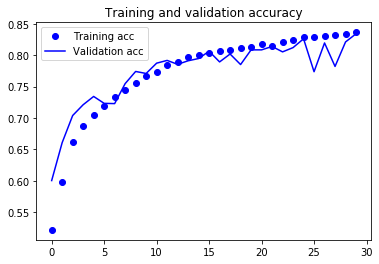

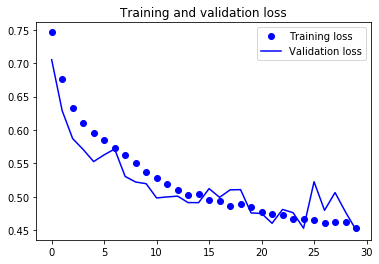

In [122]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Grafiklere bakacak olursak overfitting yapmıyoruz. Validation loss değerleri noisy olmasına rağmen büyük bir problem oluşturmuyor. Accuracy değerlerimiz önceki modele göre çok yükseldi.

----------------

If we look at the graphics, we are not overfitting. Although validation loss values are noisy, they are not a big problem. Our Accuracy values are much higher than the previous model.

In [123]:
test_generator = test_datagen.flow_from_directory(
test_dir,
target_size=(150, 150),
batch_size=20,
class_mode='binary')
test_loss, test_acc = model.evaluate(test_generator, steps=250)
print('test acc:', test_acc)

Found 5000 images belonging to 2 classes.
250/250 [==============================] - 28s 111ms/step - loss: 0.4457 - acc: 0.8338
test acc: 0.8338000178337097


Başarı oranımız %83 dolaylarında. Daha küçük bir network kullanarak daha başarılı bir sonuç elde ettik.

-------------------------

Our success rate is around 83%. We achieved a more successful result with using a smaller network.